**Описание проекта**

**Bнтернет-магазин, который продаёт по всему миру компьютерные игры. Нам нужно, при помощи исторических данных из открытых источников, о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation), выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.**

**Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.**

**В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».**

### Откроем файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly

In [2]:
try:
    data = pd.read_csv("/datasets/games.csv")
except:
    data = pd.read_csv('/games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [5]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
data.duplicated().sum()

0

#  Подготовим данные

**Наблюдаются множественные пропуски в данных, а так же некоректное название столбцов. Стобцы Year_of_Release, Critic_Score и User_Score необходимо изменить в соответвии с типом данных (Year_of_Release - int(тут всего 269 пропусков, так что их смело можем удалить), Critic_Score - int, User_Score - float64)**

**Начнём с приведение столбцов к нижнему регистру**

In [7]:
data.columns = map(str.lower, data.columns)
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

### Обработаем пропуски, которые сможем

**Так как название, жанр и рейтинг нельзя вычислить или на это уйдёт слишком много времени, заменим пропуски на unknown**

In [8]:
data.fillna(
    {'name' : 'unknown', 
     'genre' : 'unknown',
     'rating' : 'unknown'}
    , inplace=True
)

**В user_score помимо привычных NaN есть так же tbd (to be determined), думаю логично его отправить к NaN**

In [9]:
data['user_score'] = data['user_score'].replace('tbd', 'NaN')
data['user_score'] = data['user_score'].fillna(0)

**critic_score содержит NaN, но нам необходимо изменить тип столбца на int, значения заменим NaN на 0**

In [10]:
data['critic_score'] = data['critic_score'].fillna(0)

### Теперь изменим тип данных в столбцах year_of_release, critic_score и user_score

In [11]:
data = data.dropna(subset=['year_of_release'])
data['year_of_release'] = data['year_of_release'].astype('int')
data['critic_score'] = data['critic_score'].astype('int')
data['user_score'] = data['user_score'].astype('float64')
#data['na_sales'] = data['na_sales'].astype('int')
#data['eu_sales'] = data['eu_sales'].astype('int')
#data['jp_sales'] = data['jp_sales'].astype('int')
#data['other_sales'] = data['other_sales'].astype('int')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16446 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int32  
 3   genre            16446 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     16446 non-null  int32  
 9   user_score       14070 non-null  float64
 10  rating           16446 non-null  object 
dtypes: float64(5), int32(2), object(4)
memory usage: 1.4+ MB


**Пропуски в столбцах year_of_release , user_score, думаю что не стоит заполнять, иначе это может отразиться на общей картине, хотя, хоть я и заполнил critic_score, значениями 0, в будущем мы сможем просто отметать эти значения, что бы так же не искажать статистику.**

**Посчитаем суммарные продажи во всех регионах и занесём их в отдельный столбец sum_salle.**

In [13]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [14]:
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,unknown,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,0,0.0,unknown,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,0,0.0,unknown,28.31


# Проведём исследовательский анализ данных

**Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?**

<AxesSubplot: xlabel='year_of_release'>

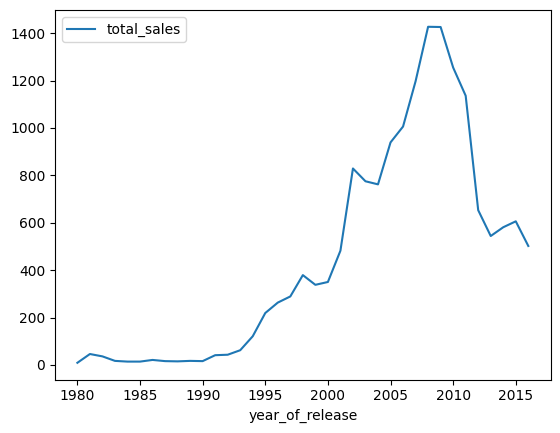

In [15]:
sales_years = pd.pivot_table(data,
                      index = 'year_of_release',
                      values = 'total_sales',
                      aggfunc=['count']
                      )
sales_years.plot(y = 'count')

**Обратим внимание что есть три точки резкого роста - это 1993, 2000, 2004, после этого в 2010 идёт спад**

In [16]:
platforms_leaders = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head()
platforms_leaders

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
Name: total_sales, dtype: float64

**Топ 5 платформ по продажам, "плойка" впереди планеты всей**

In [17]:
d = []

for platform in platforms_leaders.index:
    d.append(
        go.Scatter(y=data[data.platform==platform].groupby('year_of_release')['total_sales'].sum(), 
               name=platform )
    )
    
x = go.Figure(d)
iplot(x, show_link = False)

**Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.**

**На графике видно что многие известные платформы появились около 2005 года, думаю его и возьмём в качестве "актуальной" даты отсчёта**

**Средняя продолжительсность "жизни" платформ окло 10 лет, и судя по графику стоит ожидать появление новых платформ**

In [18]:
data_2000 = data[data['year_of_release']>=2012]
data_2000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2886 non-null   object 
 1   platform         2886 non-null   object 
 2   year_of_release  2886 non-null   int32  
 3   genre            2886 non-null   object 
 4   na_sales         2886 non-null   float64
 5   eu_sales         2886 non-null   float64
 6   jp_sales         2886 non-null   float64
 7   other_sales      2886 non-null   float64
 8   critic_score     2886 non-null   int32  
 9   user_score       2754 non-null   float64
 10  rating           2886 non-null   object 
 11  total_sales      2886 non-null   float64
dtypes: float64(6), int32(2), object(4)
memory usage: 270.6+ KB


In [19]:
platforms_leaders_2005 = data_2000.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)
platforms_leaders_2005

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
Name: total_sales, dtype: float64

**Получили топ 10 платформ**

In [20]:
d = []

for platform in platforms_leaders_2005.index:
    d.append(
        go.Scatter(y=data_2000[data_2000.platform==platform].groupby('year_of_release')['total_sales'].sum(), 
               name=platform )
    )
    
x = go.Figure(d)
iplot(x, show_link = False)

**По волнообразным графикам можно предположить, что спад популярности платформ предшествует выходу новых платформ.**
**Самыми перспективными платформами можно назвать:**

***3DS***

***XOne***

***PS4***

**Но только потому что они не достигли ещё своего "дна".**

# Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [21]:
d = []

for platform in data_2000['platform'].unique():
    d.append(
        go.Box(y=data_2000[data_2000.platform==platform]['total_sales'], 
               name=platform )
    )

x = go.Figure(d)

x.update_layout(yaxis=dict(range=[0,1]))

iplot(x, show_link = False)

x.update_layout()
iplot(x, show_link = False)

**Лучшие медеанные данные можно наблюдать у платформ Playstation (PS3, PS4) и Microsoft (X360, XOne), с отставанием, но всё равно заметно выше всех остальных у нас расположилась Nintendo (WiiU и Wii)**

# Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [22]:
topical_score = data_2000[(data_2000.critic_score > 0) & (data_2000.user_score > 0)]

,total_sales,critic_score,user_score
total_sales,1.000000,0.360573,-0.002014
critic_score,0.360573,1.000000,0.557352
user_score,-0.002014,0.557352,1.000000


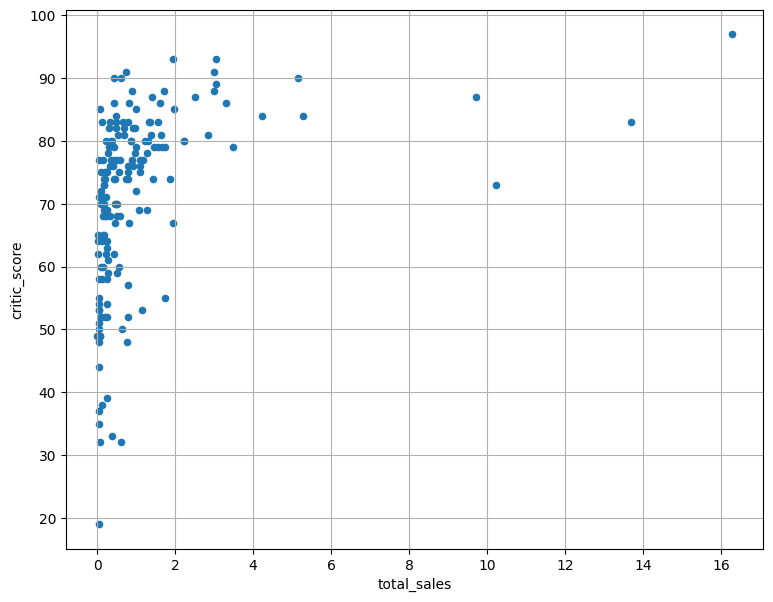

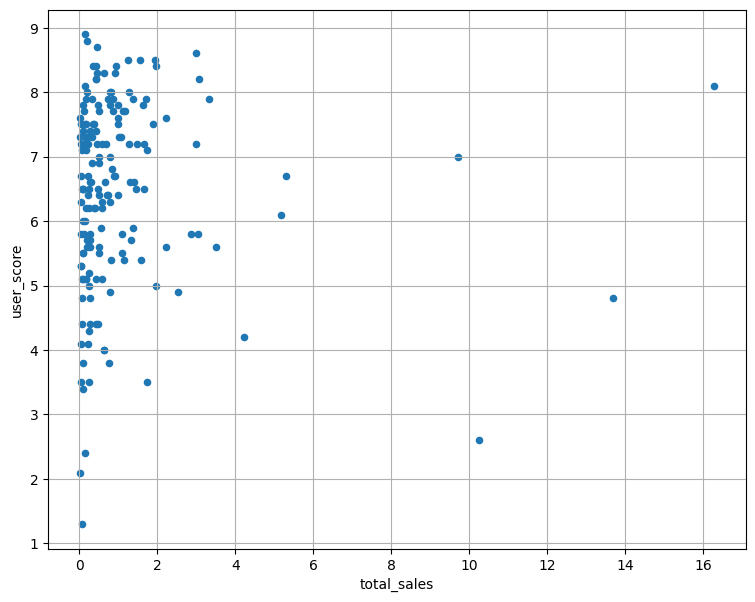

In [23]:
topical_score[topical_score.platform == 'X360'].plot(x='total_sales',
                  y = 'critic_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == 'X360'].plot(x='total_sales',
                  y = 'user_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == 'X360'][['total_sales', 'critic_score', 'user_score']].corr()

**Оценки пользователей и критиков не сильно влияют на продажи игр на X360**

,total_sales,critic_score,user_score
total_sales,1.000000,0.405895,-0.033625
critic_score,0.405895,1.000000,0.557654
user_score,-0.033625,0.557654,1.000000


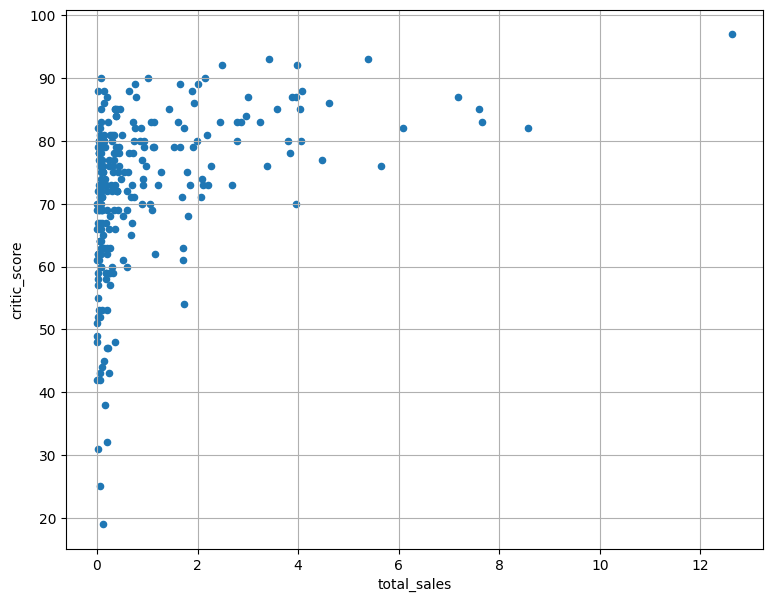

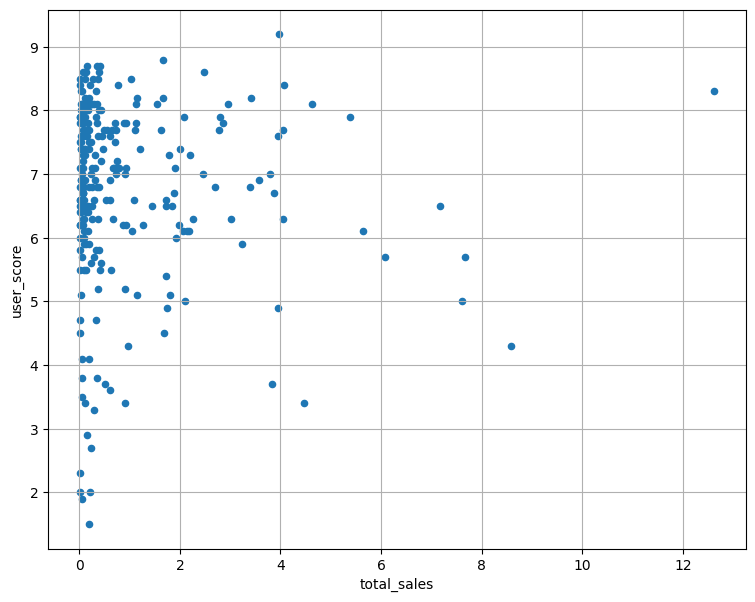

In [24]:
topical_score[topical_score.platform == 'PS4'].plot(x='total_sales',
                  y = 'critic_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == 'PS4'].plot(x='total_sales',
                  y = 'user_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == 'PS4'][['total_sales', 'critic_score', 'user_score']].corr()

**У PS4 оценки критиков сильнее влияют на продажи, но всё ещё не сильно.**

,total_sales,critic_score,user_score
total_sales,1.000000,0.310553,0.201813
critic_score,0.310553,1.000000,0.722762
user_score,0.201813,0.722762,1.000000


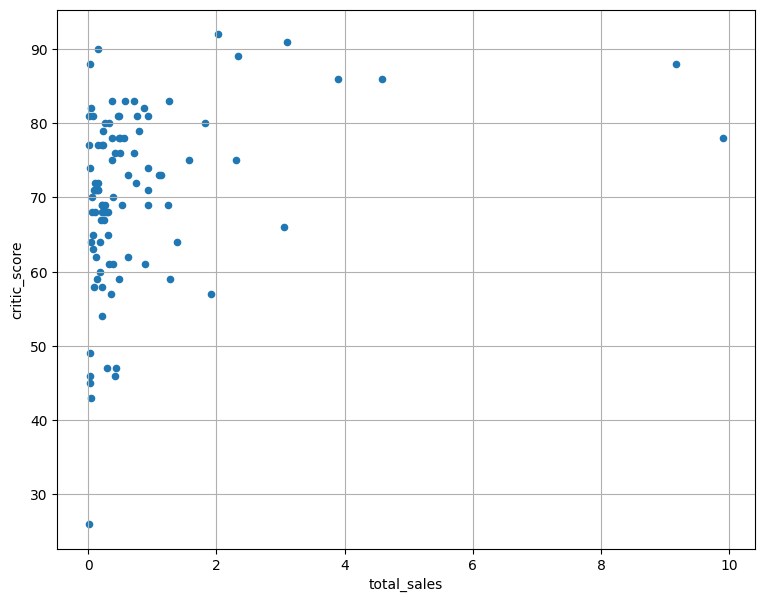

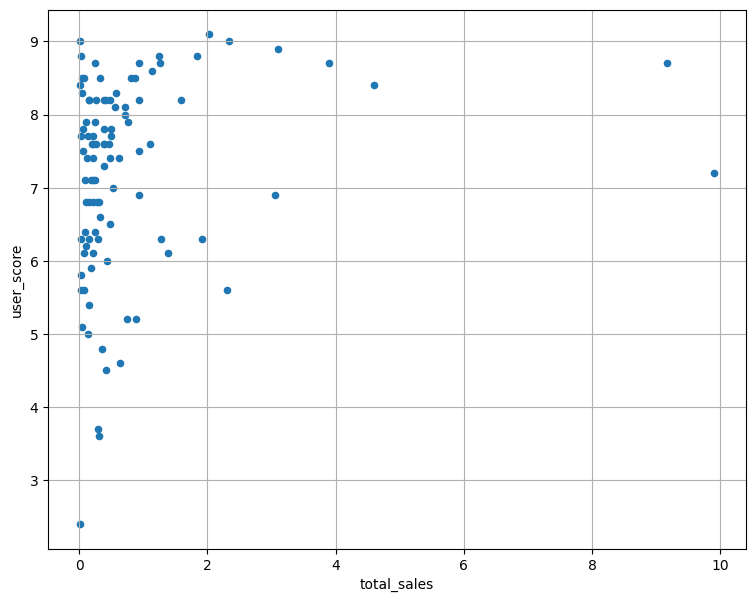

In [25]:
topical_score[topical_score.platform == '3DS'].plot(x='total_sales',
                  y = 'critic_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == '3DS'].plot(x='total_sales',
                  y = 'user_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == '3DS'][['total_sales', 'critic_score', 'user_score']].corr()

**У 3DS отзывы пользователей влияют сильно на продажи игр, возможно в Японии пользователи чаще читают отзывы товарищей**

,total_sales,critic_score,user_score
total_sales,1.000000,0.410422,-0.094003
critic_score,0.410422,1.000000,0.472462
user_score,-0.094003,0.472462,1.000000


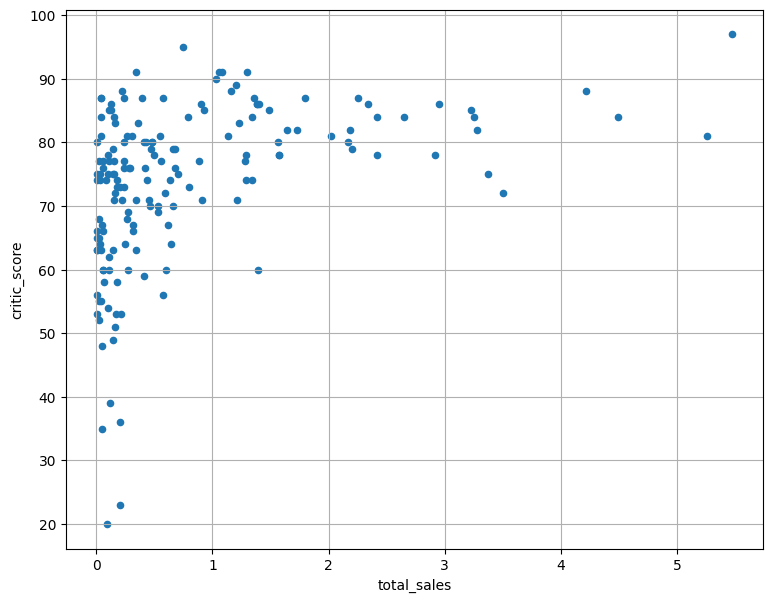

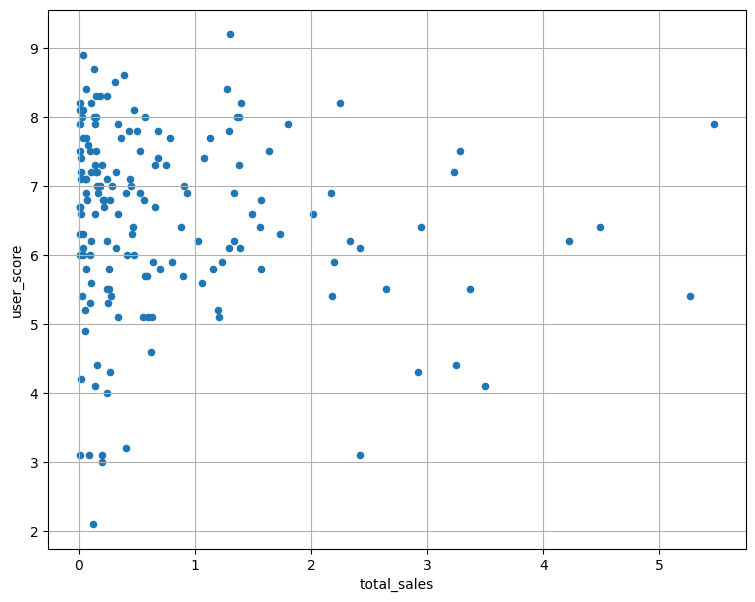

In [26]:
topical_score[topical_score.platform == 'XOne'].plot(x='total_sales',
                  y = 'critic_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == 'XOne'].plot(x='total_sales',
                  y = 'user_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == 'XOne'][['total_sales', 'critic_score', 'user_score']].corr()

**У XOne отзывы пользователей средне влияют на продажи**

,total_sales,critic_score,user_score
total_sales,1.000000,0.331057,0.003227
critic_score,0.331057,1.000000,0.539456
user_score,0.003227,0.539456,1.000000


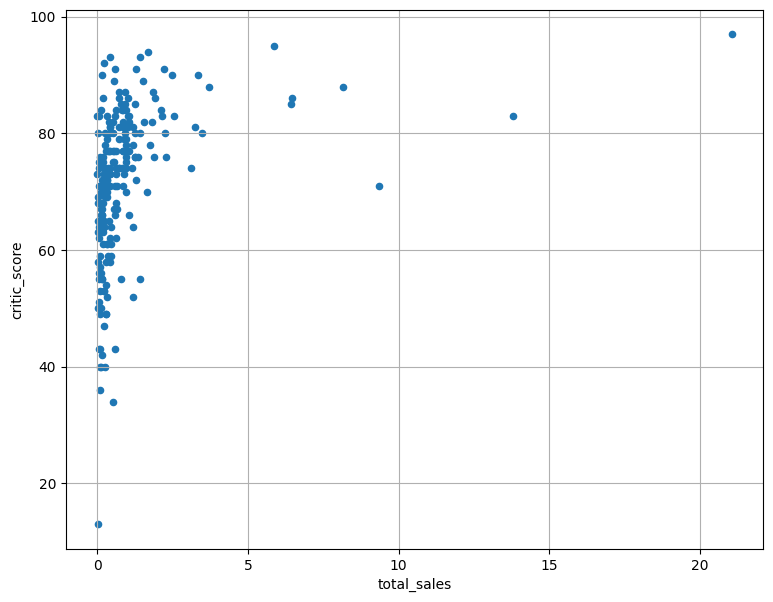

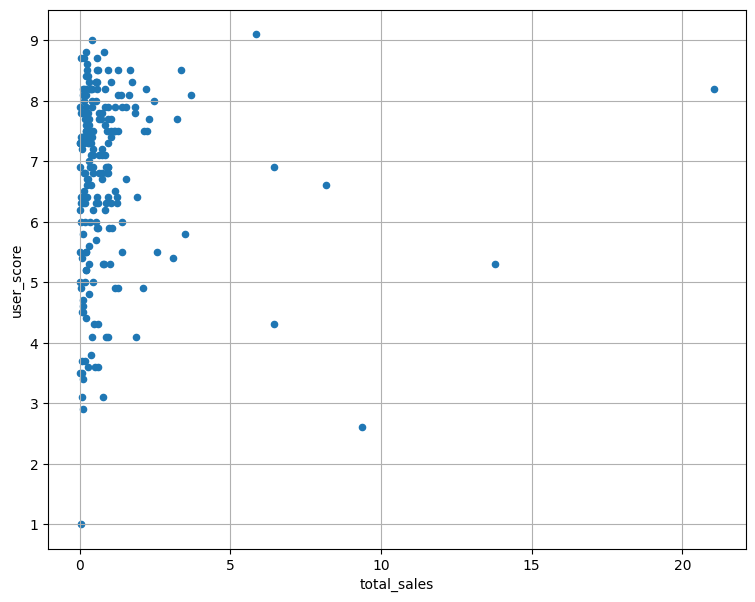

In [27]:
topical_score[topical_score.platform == 'PS3'].plot(x='total_sales',
                  y = 'critic_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == 'PS3'].plot(x='total_sales',
                  y = 'user_score',
                  kind='scatter',
                  figsize=(9, 7),
                  grid=True
                  )

topical_score[topical_score.platform == 'PS3'][['total_sales', 'critic_score', 'user_score']].corr()

**У PS3 Отзывы критиков сильнее влияют на корреляцию**

**Если взглянуть на общую корреляцию всех платформ, что становится ясно, что для западных платформ мнения пользователей и критиков не очень хорошо коррелируется с продажами, но у "восточных" платформ, пользователи чаще читают мнения других пользователей**

# Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

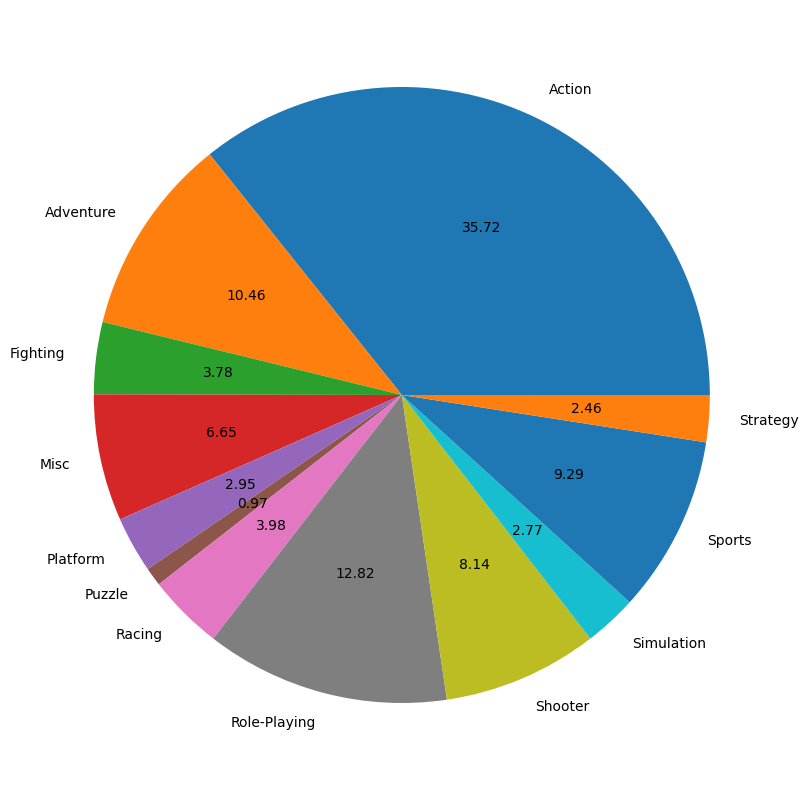

In [28]:
x=data_2000.groupby("genre")['genre'].count()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x=x, labels=genres, autopct="%.2f")
plt.show()

**Жанр Action самый популярный, спорт и misc идут на втором и третьем месте.**

In [29]:
data_2000.groupby('genre')[['total_sales']].median().sort_values('total_sales', ascending=False)

,total_sales
genre,
Shooter,0.440
Sports,0.240
Platform,0.210
Role-Playing,0.140
Racing,0.140
Fighting,0.130
Action,0.120
Misc,0.120
Simulation,0.120


**По медианной продаж можно сделать вывод, что Shooter и Sports приносят стабильный доход** 

# Шаг 4. Составьте портрет пользователя каждого региона

**Определите для пользователя каждого региона (NA, EU, JP):**

**Самые популярные платформы (топ-5). Опишите различия в долях продаж.**

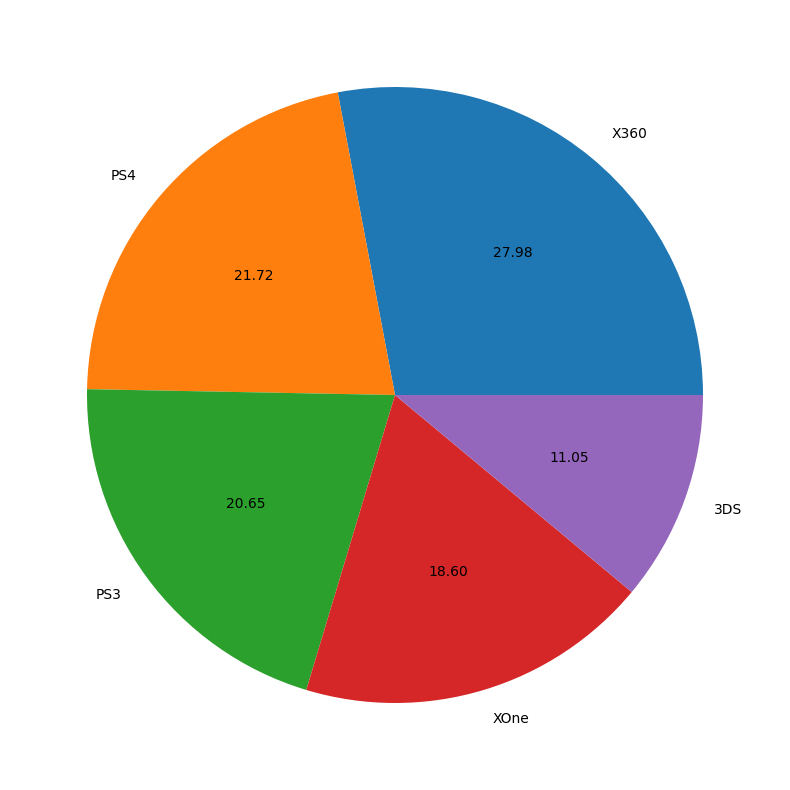

In [30]:
x = data_2000.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x=x, labels=genres, autopct="%.2f")
plt.show()

In [31]:
x.sort_values(ascending=False)

platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64

**ТОП 5 платформ по продажам в Северной Америке:**

***1. X360***

***2. Wii***

***3. PS3***

***4. DS***

***5. PS2***

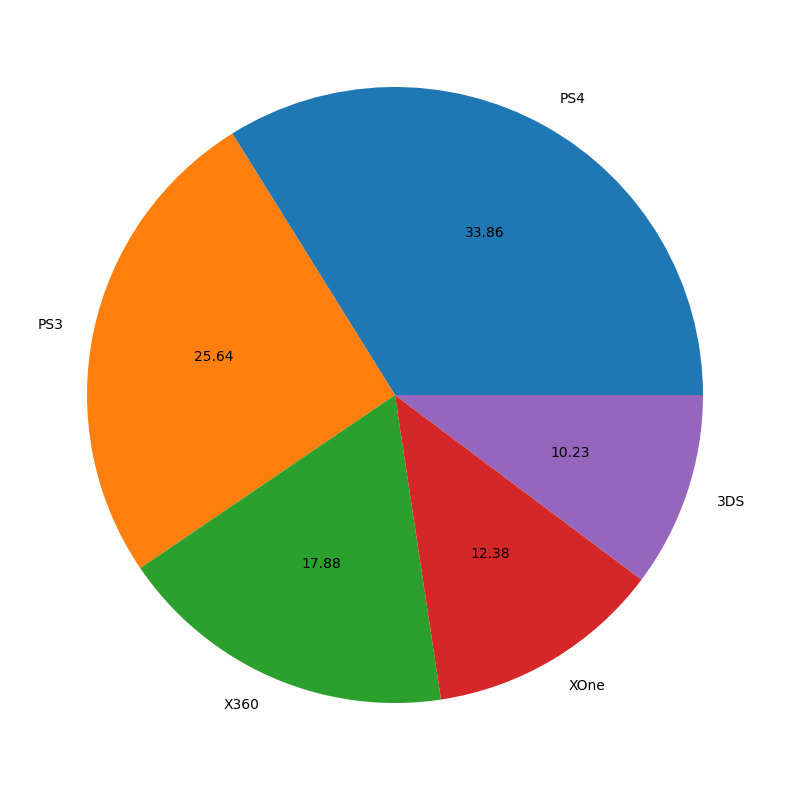

In [32]:
x = data_2000.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x=x, labels=genres, autopct="%.2f")
plt.show()

In [33]:
x.sort_values(ascending=False)

platform
PS4     141.09
PS3     106.86
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64

**ТОП 5 платформ по продажам в Европе:**

***1. PS3***

***2. X360***

***3. Wii***

***4. DS***

***5. PS4***

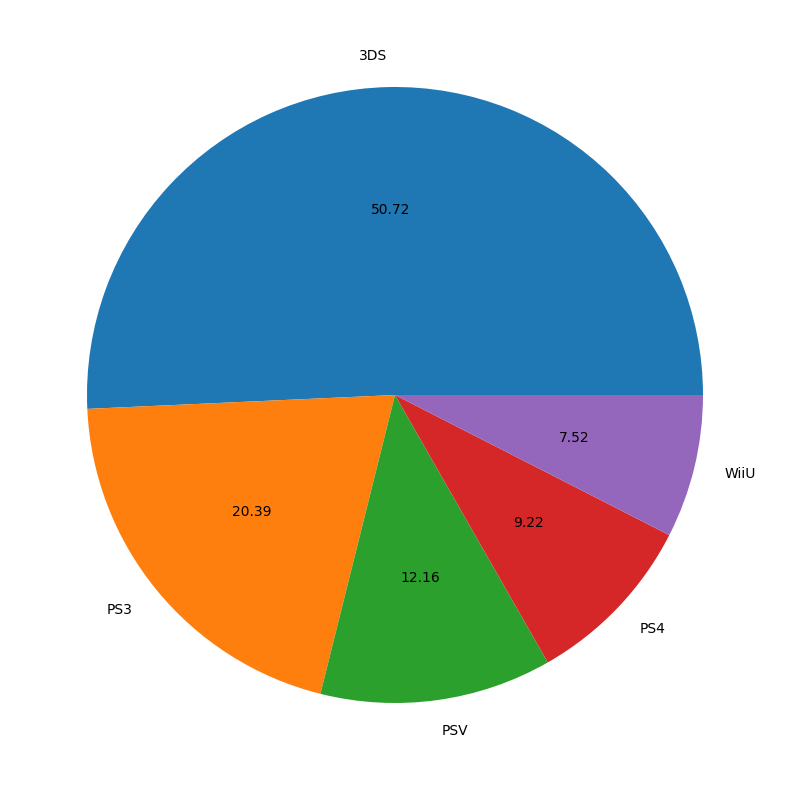

In [34]:
x = data_2000.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x=x, labels=genres, autopct="%.2f")
plt.show()

In [35]:
x.sort_values(ascending=False)

platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64

**ТОП 5 платформ по продажам в Японии:**

***1. DS***

***2. 3DS***

***3. PS3***

***4. PSP***

***5. Wii***

**В Северной Америке и Японии складывается типичная ситуация, когда региональные производители доминируют, а вот в Европе видна настоящая борьба, так как местного производства платформ там нет**

# Самые популярные жанры (топ-5). Поясните разницу.

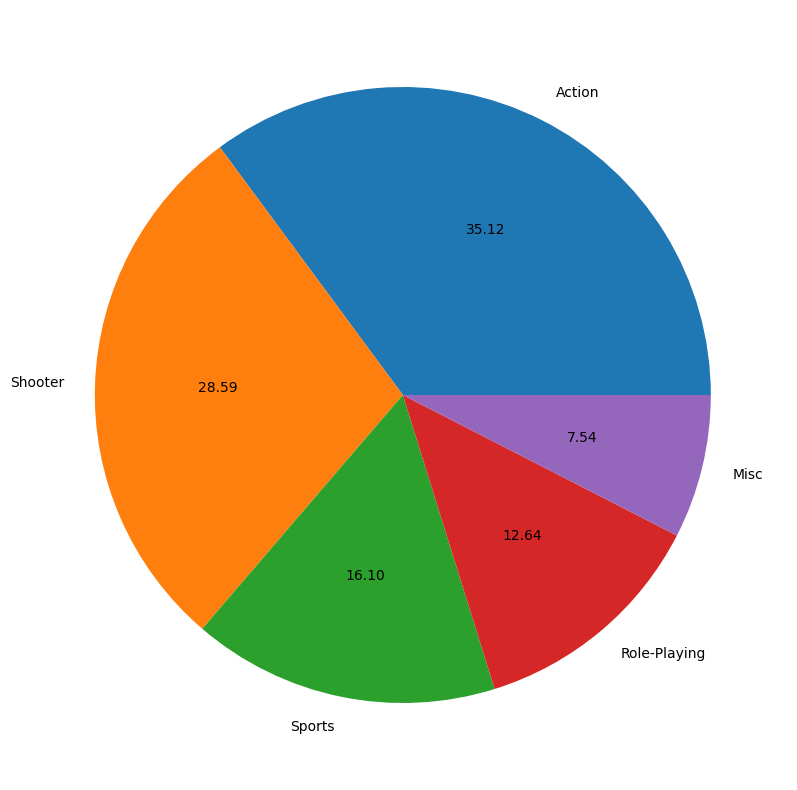

In [36]:
x = data_2000.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x, labels=genres, autopct="%.2f")
plt.show()

In [37]:
print('ТОП 5 жанров в Северной Америке:')
x.sort_values(ascending=False)

ТОП 5 жанров в Северной Америке:


genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64

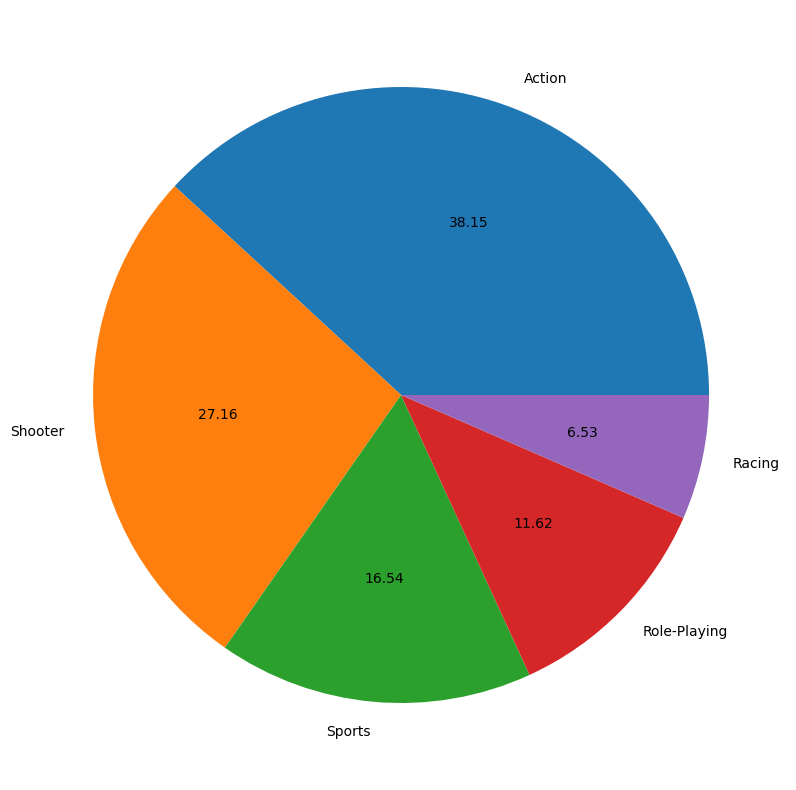

In [38]:
x = data_2000.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x, labels=genres, autopct="%.2f")
plt.show()

In [39]:
print('ТОП 5 жанров в Европе:')
x.sort_values(ascending=False)

ТОП 5 жанров в Европе:


genre
Action          159.34
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64

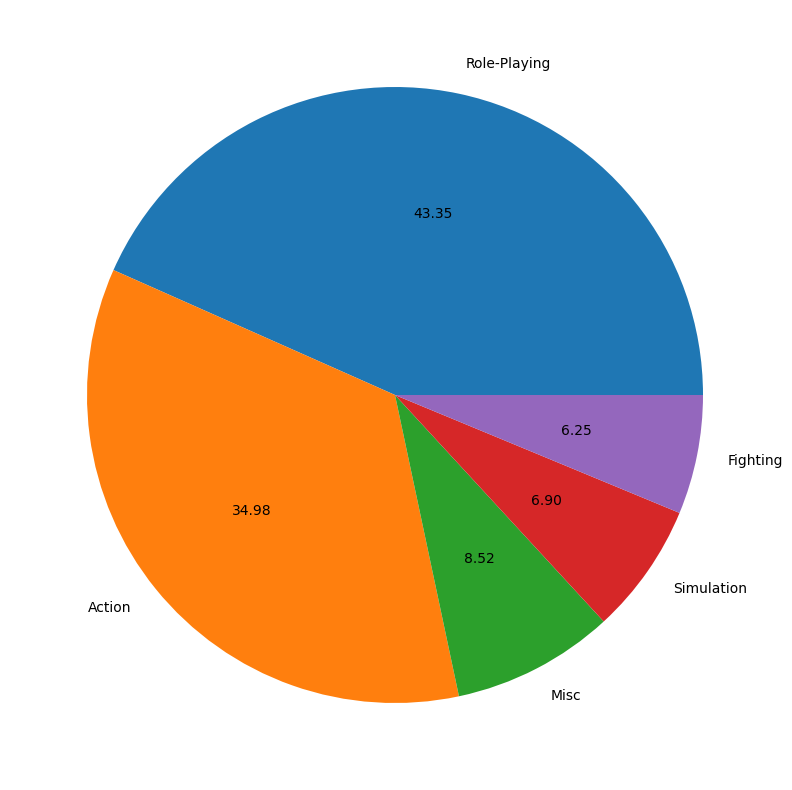

In [40]:
x = data_2000.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x, labels=genres, autopct="%.2f")
plt.show()

In [41]:
print('ТОП 5 жанров в Японии:')
x.sort_values(ascending=False)

ТОП 5 жанров в Японии:


genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64

**В Северной Америке и Европе доминируют "экшены" и "шутеры"**

**Как можно заметить в Японии намного более популярен жанр RP, что вполне становится понятно, ведь большинство игр выпускаемые на региональных платформах - это именно RP. Похоже в Японии любят отыгрывать роли =)**

# Влияет ли рейтинг ESRB на продажи в отдельном регионе?

**Посмотрим на продажи в зависимости от рейтинга в Северной Америке:**

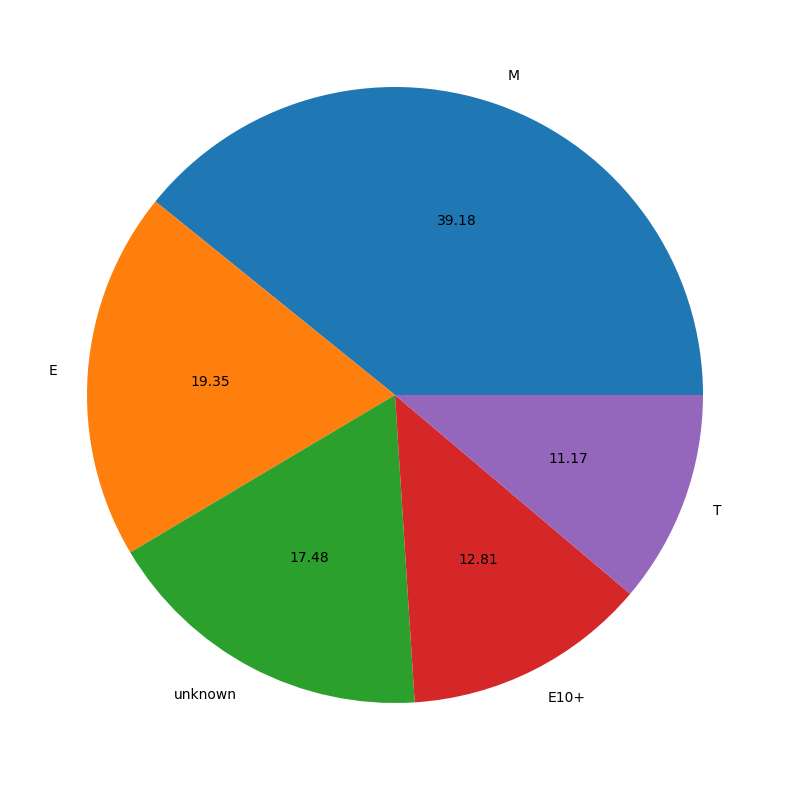

In [42]:
x = data_2000.groupby('rating')['na_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x, labels=genres, autopct="%.2f")
plt.show()

In [43]:
print('ТОП 5 возростных рейтингов в Северной Америке:')
x.sort_values(ascending=False)

ТОП 5 возростных рейтингов в Северной Америке:


rating
M          231.57
E          114.37
unknown    103.31
E10+        75.70
T           66.02
Name: na_sales, dtype: float64

**Посмотрим на продажи в зависимости от рейтинга в Европе:**

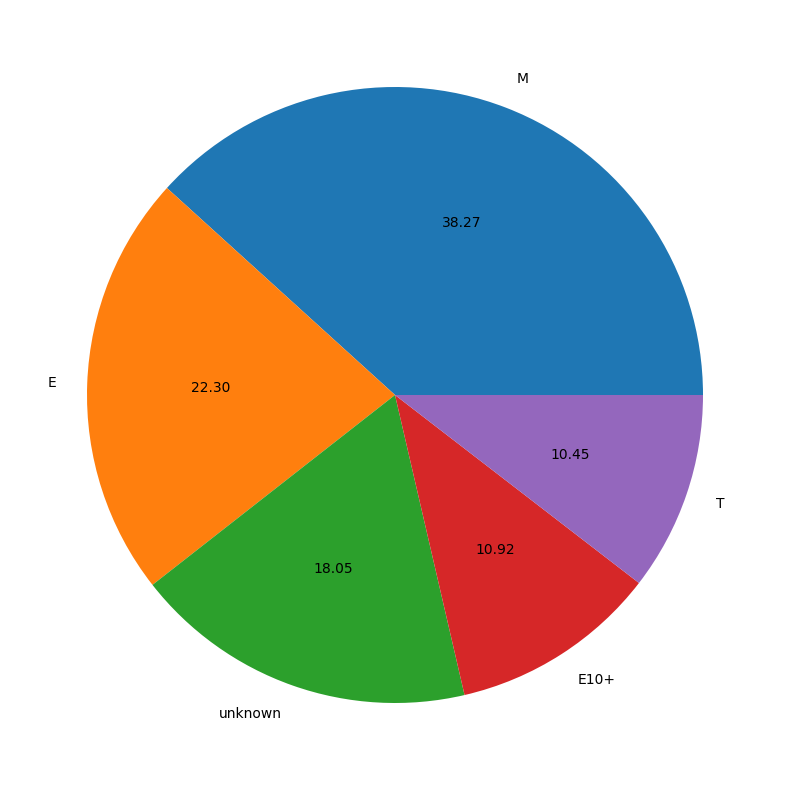

In [44]:
x = data_2000.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x, labels=genres, autopct="%.2f")
plt.show()

In [45]:
print('ТОП 5 возростных рейтингов в Европе:')
x.sort_values(ascending=False)

ТОП 5 возростных рейтингов в Европе:


rating
M          193.96
E          113.03
unknown     91.50
E10+        55.37
T           52.96
Name: eu_sales, dtype: float64

**Посмотрим на продажи в зависимости от рейтинга в Японии:**

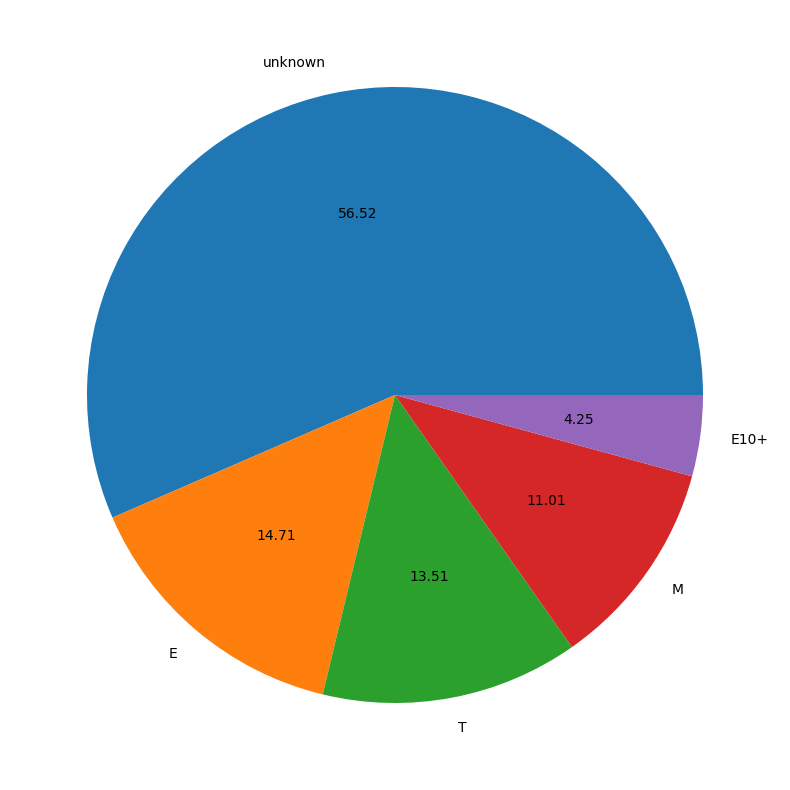

In [46]:
x = data_2000.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).head()
genres = x.index
plt.figure(figsize=(20,10))
plt.pie(x, labels=genres, autopct="%.2f")
plt.show()

In [47]:
print('ТОП 5 возростных рейтингов в Японии:')
x.sort_values(ascending=False)

ТОП 5 возростных рейтингов в Японии:


rating
unknown    108.84
E           28.33
T           26.02
M           21.20
E10+         8.19
Name: jp_sales, dtype: float64

**Из данных становится понятно, что в США и Европе лидируют игры с рейтингом Е (для всех возрастов), далее идут М (для взрослых), но вот в Японии лидируют игры без рейтинга, что скорее всего обусловленно именно тем что региональные издатели не получают рейтинг на заподном рынке, так как ориентированы на внутрений**

# Шаг 5. Проверьте гипотезы

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;**

**H_0 (нулевая гипотеза) - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;**

**H_1 (альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.**

In [48]:
H_0 = data_2000[(data_2000['platform'] == 'XOne') & (data_2000['user_score'] > 0)]['user_score']
H_1 = data_2000[(data_2000['platform'] == 'PC') & (data_2000['user_score'] > 0)]['user_score']
results = stats.ttest_ind(H_0, H_1, equal_var=False)

alpha = 0.05

print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

NameError: name 'stats' is not defined

**Используя актуальный период, можно понять что средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

**H_0 (нулевая гипотеза) - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.**

**H_1 (альтернативная гипотеза) - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

In [ ]:
H_0 = data_2000[(data_2000['genre'] == 'Action') & (data_2000['user_score'] > 0)]['user_score']
H_1 = data_2000[(data_2000['genre'] == 'Sports') & (data_2000['user_score'] > 0)]['user_score']
results = stats.ttest_ind(H_0, H_1)

alpha = 0.05

print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

3.716308946093486e-26
Отвергаем нулевую гипотезу


**Используя актуальный период, можно понять что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные**

# Шаг 6. Напишите общий вывод

**Ознакомился с данными, посмотрели на общую информацию о датасете, выявили пропуски и не соответствие типов данных.**

**Заполнил пропуски, изменил типы данных в столбцах, переименовал столбцы**

**Есть три точки резкого роста популярности платформ - это 1993, 2000, 2004, после этого в 2010 идёт спад**

**"Срок жизни платформы" окло 10 лет**

**Платформы 3DS, XOne, PS4, ещё не закончили своё падение, но вперспективе можно ожидать выхода новых, на них бы и делал ставку**

**Сравнили продаваемость платформ в различных регионах. В Северной Америке и Японии сложилась типичная ситуация, когда региональные производители доминируют, а вот в Европе видна настоящая борьба, так как местного производства платформ там нет**

**В Северной Америке и Европе доминируют "экшены" и "шутеры".В Японии намного более популярен жанр RP, что вполне становится понятно, ведь большинство игр выпускаемые на региональных платформах - это именно RP**

**Выявил самые популярные рейтинги в разных регионах. И выяснили, что в США и Европе лидируют игры с рейтингом Е (для всех возрастов), далее идут М (для взрослых), но вот в Японии лидируют игры без рейтинга, что скорее всего обусловленно именно тем что региональные издатели не получают рейтинг на заподном рынке, так как ориентированы на внутрений**

**Проверили 2 гопотезы:**

**1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; (оказалось что нет).**

**2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. (оказалось что так и есть)**